In [1]:
%matplotlib notebook
import sys
sys.path.append('train_eval')
sys.path.append('preprocess')
from preprocess_blender import *
from IPython.display import Image, display
import torch
import torch.nn as nn
import math
from utils import group_points_2

In [2]:
nstates_plus_1 = [64,64,128]
nstates_plus_2 = [128,128,256]
nstates_plus_3 = [256,512,1024,1024,512]

class PointNet_Plus(nn.Module):
    def __init__(self):
        super(PointNet_Plus, self).__init__()
        self.num_outputs = 26
        self.knn_K = 64
        self.ball_radius2 = 0.04
        self.sample_num_level1 = 512
        self.sample_num_level2 = 128
        self.INPUT_FEATURE_NUM = 6
        
        self.netR_1 = nn.Sequential(
            # B*INPUT_FEATURE_NUM*sample_num_level1*knn_K
            nn.Conv2d(self.INPUT_FEATURE_NUM, nstates_plus_1[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[0]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[0], nstates_plus_1[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[1]),
            nn.ReLU(inplace=True),
            # B*64*sample_num_level1*knn_K
            nn.Conv2d(nstates_plus_1[1], nstates_plus_1[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_1[2]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level1*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*128*sample_num_level1*1
        )
        
        self.netR_2 = nn.Sequential(
            # B*131*sample_num_level2*knn_K
            nn.Conv2d(3+nstates_plus_1[2], nstates_plus_2[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[0]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[0], nstates_plus_2[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[1]),
            nn.ReLU(inplace=True),
            # B*128*sample_num_level2*knn_K
            nn.Conv2d(nstates_plus_2[1], nstates_plus_2[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_2[2]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*knn_K
            nn.MaxPool2d((1,self.knn_K),stride=1)
            # B*256*sample_num_level2*1
        )
        
        self.netR_3 = nn.Sequential(
            # B*259*sample_num_level2*1
            nn.Conv2d(3+nstates_plus_2[2], nstates_plus_3[0], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[0]),
            nn.ReLU(inplace=True),
            # B*256*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[0], nstates_plus_3[1], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[1]),
            nn.ReLU(inplace=True),
            # B*512*sample_num_level2*1
            nn.Conv2d(nstates_plus_3[1], nstates_plus_3[2], kernel_size=(1, 1)),
            nn.BatchNorm2d(nstates_plus_3[2]),
            nn.ReLU(inplace=True),
            # B*1024*sample_num_level2*1
            nn.MaxPool2d((self.sample_num_level2,1),stride=1),
            # B*1024*1*1
        )
        
        self.netR_FC = nn.Sequential(
            # B*1024
            nn.Linear(nstates_plus_3[2], nstates_plus_3[3]),
            nn.BatchNorm1d(nstates_plus_3[3]),
            nn.ReLU(inplace=True),
            # B*1024
            nn.Linear(nstates_plus_3[3], nstates_plus_3[4]),
            nn.BatchNorm1d(nstates_plus_3[4]),
            nn.ReLU(inplace=True),
            # B*512
            nn.Linear(nstates_plus_3[4], self.num_outputs),
            # B*num_outputs
        )
    def forward(self, x, y):
        # x: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, y: B*3*sample_num_level1*1
        x = self.netR_1(x)
        # B*128*sample_num_level1*1
        x = torch.cat((y, x),1).squeeze(-1)
        # B*(3+128)*sample_num_level1
        
        inputs_level2, inputs_level2_center = group_points_2(x, self.sample_num_level1, self.sample_num_level2, self.knn_K, self.ball_radius2)
        # B*131*sample_num_level2*knn_K, B*3*sample_num_level2*1
        
        # B*131*sample_num_level2*knn_K
        x = self.netR_2(inputs_level2)
        # B*256*sample_num_level2*1
        x = torch.cat((inputs_level2_center, x),1)
        # B*259*sample_num_level2*1
        
        x = self.netR_3(x)
        # B*1024*1*1
        x = x.view(-1,nstates_plus_3[2])
        # B*1024
        x = self.netR_FC(x)
        # B*num_outputs
        
        return x

In [3]:
def simple_plot(points):
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    fig = pyplot.figure()
    ax = Axes3D(fig)
    ax.scatter(points[:,0], points[:,1], points[:,2], c='b')
    ax.view_init(90,-90)

In [4]:
def group_points(points):
    sample_num_level1 = 512
    sample_num_level2 = 128
    ball_radius       = 0.015
    ball_radius2      = 0.04
    SAMPLE_NUM        = 1024
    knn_K             = 64
    INPUT_FEATURE_NUM = 6
    # group points using knn and ball query
    # points: B * 1024 * 6
   
    cur_train_size = len(points)
    inputs1_diff = points[:,:,0:3].transpose(1,2).unsqueeze(1).expand(cur_train_size,sample_num_level1,3, SAMPLE_NUM) \
                 - points[:,0:sample_num_level1,0:3].unsqueeze(-1).expand(cur_train_size,sample_num_level1,3,SAMPLE_NUM)# B * 512 * 3 * 1024
    inputs1_diff = torch.mul(inputs1_diff, inputs1_diff)    # B * 512 * 3 * 1024
    inputs1_diff = inputs1_diff.sum(2)                      # B * 512 * 1024
    dists, inputs1_idx = torch.topk(inputs1_diff, knn_K, 2, largest=False, sorted=False)  # dists: B * 512 * 64; inputs1_idx: B * 512 * 64
        
    # ball query
    invalid_map = dists.gt(ball_radius) # B * 512 * 64
    for jj in range(sample_num_level1):
        inputs1_idx[:,jj,:][invalid_map[:,jj,:]] = jj
        
    idx_group_l1_long = inputs1_idx.view(cur_train_size,sample_num_level1*knn_K,1).expand(cur_train_size,sample_num_level1*knn_K,INPUT_FEATURE_NUM)
    inputs_level1 = points.gather(1,idx_group_l1_long).view(cur_train_size,sample_num_level1,knn_K,INPUT_FEATURE_NUM) # B*512*64*6

    inputs_level1_center = points[:,0:sample_num_level1,0:3].unsqueeze(2)       # B*512*1*3
    inputs_level1[:,:,:,0:3] = inputs_level1[:,:,:,0:3] - inputs_level1_center.expand(cur_train_size,sample_num_level1,knn_K,3)
    inputs_level1 = inputs_level1.unsqueeze(1).transpose(1,4).squeeze(4)  # B*6*512*64
    inputs_level1_center = inputs_level1_center.contiguous().view(-1,1,sample_num_level1,3).transpose(1,3)  # B*3*512*1
    return inputs_level1, inputs_level1_center
    #inputs_level1: B*INPUT_FEATURE_NUM*sample_num_level1*knn_K, inputs_level1_center: B*3*sample_num_level1*1

In [5]:
data_root = '/Volumes/AndrewJayZhou/Dataset/FootPoseDepth/syn/v3_40k'
depth_map = os.path.join(data_root, 'o2_0001', '0018.exr')
gt        = os.path.join(data_root, 'o2_0001', '0018_joint_pos.txt')
pc, coeff, max_bb3d_len, offset, jnt_xyz_normalized = preprocess(depth_map, gt, add_noise=True)
point_cloud = torch.from_numpy(pc.reshape((1,1024,6))).float()

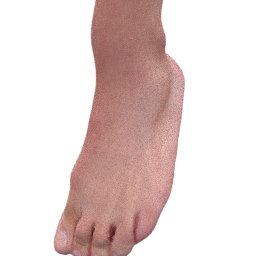

In [6]:
display(Image(filename=os.path.join(data_root, 'o2_0001', '0018.png')))

<IPython.core.display.Javascript object>


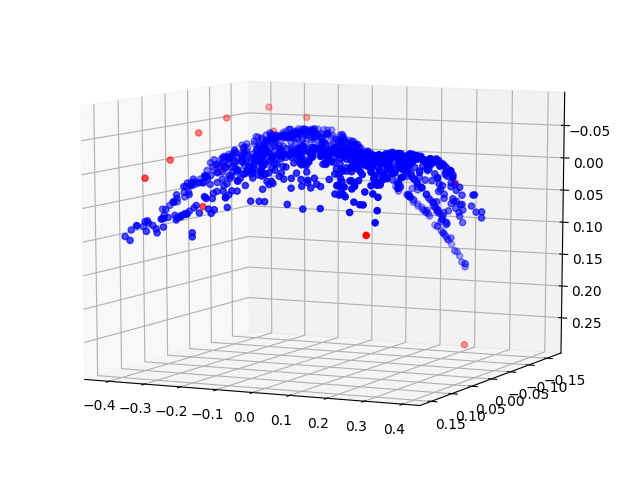

In [7]:
plot(pc,jnt_xyz_normalized)

In [11]:
def net(point_cloud):
    point_cloud = torch.from_numpy(point_cloud.reshape((1,1024,6))).float()
    # load net
    netR = PointNet_Plus()
    weight_path = 'results/iter_002/netR_45.pth'
    netR.load_state_dict(torch.load(weight_path, map_location='cpu'))
    netR.eval()

    # feed forward
    inputs_level1, inputs_level1_center = group_points(point_cloud)
    estimation = netR(inputs_level1, inputs_level1_center)
    
    # PCA info
    PCA_data_path = '/Volumes/AndrewJayZhou/Dev/HandPointNet/data/v3_40k'
    PCA_coeff_mat = np.load(os.path.join(PCA_data_path, 'PCA_coeff.npy'))

    PCA_coeff = torch.from_numpy(PCA_coeff_mat[:, 0:26].astype(np.float32))
    PCA_mean_mat = np.load(os.path.join(PCA_data_path, 'PCA_mean_xyz.npy'))
    PCA_mean = torch.from_numpy(PCA_mean_mat.astype(np.float32))

    PCA_coeff = PCA_coeff.transpose(0, 1)
    PCA_mean = PCA_mean.view(1,-1)
    
    # output
    outputs_xyz = PCA_mean.expand(1, PCA_mean.size(1))
    outputs_xyz = torch.addmm(outputs_xyz, estimation.data, PCA_coeff)
    outputs_xyz = outputs_xyz.numpy().reshape((13,3))
    return outputs_xyz

<IPython.core.display.Javascript object>


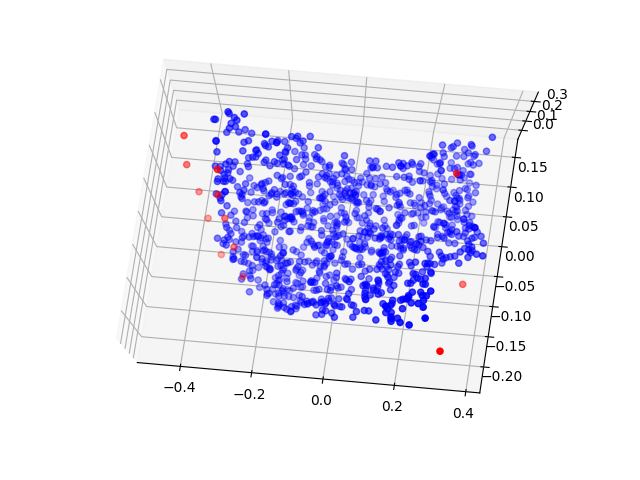

In [12]:
pred = net(pc)
plot(pc, pred)

In [13]:
def preprocess_rs(depth_map_path):
    depth_scale = 0.0010000000474974513
    f           = 320.8097839355469
    
    # 1. Read depth files 
    img_width = 200
    img_height = 200
    bb_left = 0
    bb_top = 0
    bb_right = img_width
    bb_bottom = img_height
    bb_width = bb_right - bb_left
    bb_height = bb_bottom - bb_top
    valid_pixel_num = bb_width * bb_height
    
    depth_map = np.load(depth_map_path)
#     depth_map = depth_map[70:,:]
    print(depth_map.shape)
    # 2. Convert Depth to XYZ
    MAX_DEPTH = 1 / depth_scale # z clip
    foot_3d = np.zeros((valid_pixel_num, 3))
    for i in range(0, bb_height):
      for j in range(0, bb_width):
        idx = j * bb_height + i
        z = depth_map[i][j]
        foot_3d[idx][0] = -1 * (img_width / 2. - (j + bb_left)) / f * z
        foot_3d[idx][1] = (img_height / 2. - (i + bb_top)) /f * z 
        foot_3d[idx][2] = z

    # remove entries where all 3D values are equal to 0
    foot_points = foot_3d[(foot_3d[:,0] != 0) | (foot_3d[:,1] != 0) | (foot_3d[:,2] != 0)]
    # remove entries where z value is above MAX_Z
    foot_points = foot_points[abs(foot_points[:,2])<MAX_DEPTH]

    # 3. Create OBB
    pca = PCA(n_components=3)
    pca.fit(foot_points)
    coeff = np.transpose(pca.components_)

    # Check if this rotation is what we want
    if coeff[1][0] < 0 : coeff[:,0] = -1 * coeff[:,0]
    if coeff[2][2] < 0 : coeff[:,2] = -1 * coeff[:,2]
    coeff[:,1] = np.cross(coeff[:,2], coeff[:,0])
    foot_points_rotate = np.matmul(foot_points, coeff)

    # 4. Sampling
    NUM_POINTS = foot_points.shape[0]
    SAMPLE_NUM = 1024

    if NUM_POINTS < SAMPLE_NUM: # repeat points if the total number is less than sampled
      tmp = math.floor(SAMPLE_NUM / NUM_POINTS)
      rand_ind = []
      for i in range(tmp):
        rand_ind.append([i for i in range(NUM_POINTS)])
      rand_ind = np.append(np.asarray(rand_ind), np.random.choice(NUM_POINTS, SAMPLE_NUM % NUM_POINTS))
    else:
      rand_ind = np.random.choice(NUM_POINTS, SAMPLE_NUM)

    foot_points_sampled = foot_points[rand_ind,:]
    foot_points_rotate_sampled = foot_points_rotate[rand_ind, :]
    

    # 5. Compute Surface Normal
    normals = pptk.estimate_normals(points=foot_points, k=30, r=np.inf, verbose=False)
    normals_sampled = normals[rand_ind]
    sensor_center = np.array([0, 0, 0])

    for k in range(SAMPLE_NUM):
      p1 = sensor_center - foot_points_sampled[k, :]
      angle = np.arctan2(np.linalg.norm(np.cross(p1, normals_sampled[k, :])), np.dot(p1, normals_sampled[k, :]))
      if angle > math.pi / 2 or angle < -1 * math.pi / 2: normals_sampled[k, :] = -1 * normals_sampled[k, :]

    normals_sampled_rotate = np.matmul(normals_sampled, coeff)

    # 6. Normalize Point Cloud
    x_min, x_max = np.min(foot_points_rotate[:, 0]), np.max(foot_points_rotate[:, 0])
    y_min, y_max = np.min(foot_points_rotate[:, 1]), np.max(foot_points_rotate[:, 1])
    z_min, z_max = np.min(foot_points_rotate[:, 2]), np.max(foot_points_rotate[:, 2])

    SCALE = 1.2
    bb3d_x_len = SCALE * (x_max - x_min)
    bb3d_y_len = SCALE * (y_max - y_min)
    bb3d_z_len = SCALE * (z_max - z_min)
    max_bb3d_len = max(bb3d_x_len, bb3d_y_len, bb3d_z_len)
    foot_points_normalized_sampled = foot_points_rotate_sampled / max_bb3d_len

    if NUM_POINTS < SAMPLE_NUM: offset = np.mean(foot_points_rotate, axis=0) / max_bb3d_len
    else: offset = np.mean(foot_points_normalized_sampled, axis=0)

    foot_points_normalized_sampled -= offset

    # 7. FPS Sampling
    pc = np.hstack((foot_points_normalized_sampled, normals_sampled_rotate))

    # 1st level
    sampled_idx_l1 = farthest_point_sampling_fast(foot_points_normalized_sampled, 512)
    other_idx = np.setdiff1d(np.asarray([i for i in range(SAMPLE_NUM)]), sampled_idx_l1)
    new_idx = np.append(sampled_idx_l1, other_idx)
    pc = pc[new_idx, :]

    # 2nd level
    sampled_idx_l2 = farthest_point_sampling_fast(pc[0:512, 0:2], 128)
    other_idx = np.setdiff1d(np.asarray([i for i in range(512)]), sampled_idx_l2)
    new_idx = np.append(sampled_idx_l2, other_idx)
    pc[0:512, :] = pc[new_idx, :]
   
    return pc, coeff, max_bb3d_len, offset

(200, 200)


<IPython.core.display.Javascript object>


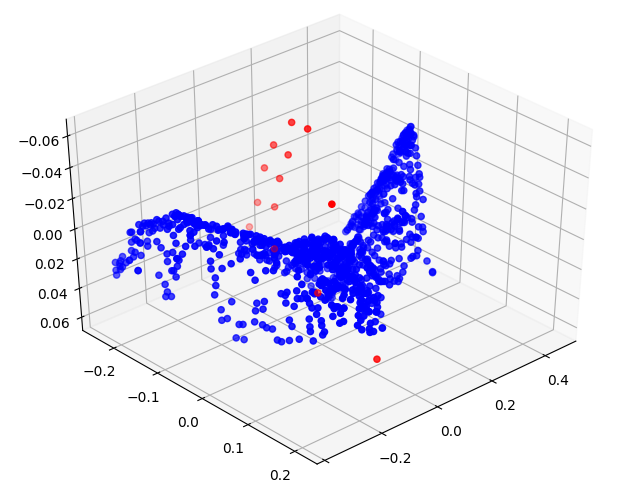

In [14]:
sample_path = '/Volumes/AndrewJayZhou/Dataset/FootPoseDepth/test/sample000004.npy'
pc, coeff, max_bb3d_len, offset = preprocess_rs(sample_path)
plot(pc, net(pc))